In [3]:
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import itertools

import keras
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.models import Sequential
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import load_model
from keras import layers
from keras import Input
from keras.models import Model

from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

170500096/170498071 [==============================] - 4s 0us/step


In [4]:
x_train_mean = np.mean(x_train)
x_train_std  = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean) / x_train_std


print(np.unique(y_train))

x_test  = (x_test - x_train_mean) / x_train_std 
y_test = to_categorical(y_test)


x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 1201)
y_validate = to_categorical(y_validate)
y_train = to_categorical(y_train)

[0 1 2 3 4 5 6 7 8 9]


In [9]:
y_train.shape

(40000, 10)

In [5]:
from keras.layers import ReLU
from keras.layers import Add

def relu_bn(inputs):
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x, downsample, filters, kernel_size: int = 3):
    y = Conv2D(kernel_size=kernel_size, strides= (1 if not downsample else 2), filters=filters,padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size, strides=1, filters=filters, padding="same")(y)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size, strides=1, filters=filters, padding="same")(y)
    y = relu_bn(y)

    if downsample:
        x = Conv2D(kernel_size=1, strides=2, filters=filters, padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def resnet_architecture():
    
    input_layer = Input(shape=(32, 32, 3))
    
    #model1: block2
    block1_Conv1 =  layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(input_layer)
    block1_MPool1 = layers.MaxPooling2D(2)(block1_Conv1)
    block1_Bn1 =    BatchNormalization()(block1_MPool1)

    block1_Conv2 =  layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(block1_Bn1)
    block1_MPool2 = layers.MaxPooling2D(2)(block1_Conv2)
    block1_Bn2 =    BatchNormalization()(block1_MPool2)
    
    #residual block
    output_residual = residual_block(block1_Bn2, downsample=(True), filters=128)
    
    #dense block
    dense1_dp1 =    Dropout(0.50)(output_residual)
    dense1_flt =    layers.Flatten()(dense1_dp1)

    dense1_dense1 = layers.Dense(512, activation = 'relu')(dense1_flt)
    dense1_Bn1 =    BatchNormalization()(dense1_dense1)
    dense1_dp2 =    Dropout(0.50)(dense1_Bn1)

    output_layer = layers.Dense(10,activation = 'softmax')(dense1_dp2)

    model = Model(inputs = input_layer, outputs = output_layer)
    
    return model

model3 = resnet_architecture() # or create_plain_net()
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 32)   128         max_pooling2d_1[0][0]            
____________________________________________________________________________________________

In [12]:
model3.compile(loss='categorical_crossentropy',
               optimizer= RMSprop(),
               metrics=['accuracy'])
history3 = model3.fit(x_train, y_train,
           epochs=35,
           batch_size = 100,
           validation_data = (x_validate, y_validate),
           verbose = 1)     
    

          

Train on 40000 samples, validate on 10000 samples
Epoch 1/35
40000/40000 [==============================] - 186s 5ms/step - loss: 1.0954 - accuracy: 0.6212 - val_loss: 1.0408 - val_accuracy: 0.6455
Epoch 2/35
40000/40000 [==============================] - 187s 5ms/step - loss: 0.8590 - accuracy: 0.7003 - val_loss: 0.8036 - val_accuracy: 0.7240
Epoch 3/35
40000/40000 [==============================] - 186s 5ms/step - loss: 0.7223 - accuracy: 0.7462 - val_loss: 0.8023 - val_accuracy: 0.7280
Epoch 4/35
40000/40000 [==============================] - 185s 5ms/step - loss: 0.6224 - accuracy: 0.7846 - val_loss: 0.7360 - val_accuracy: 0.7513
Epoch 5/35
40000/40000 [==============================] - 184s 5ms/step - loss: 0.5334 - accuracy: 0.8127 - val_loss: 0.7286 - val_accuracy: 0.7655
Epoch 6/35
40000/40000 [==============================] - 186s 5ms/step - loss: 0.4529 - accuracy: 0.8417 - val_loss: 0.7442 - val_accuracy: 0.7677
Epoch 7/35
40000/40000 [==============================] - 185s

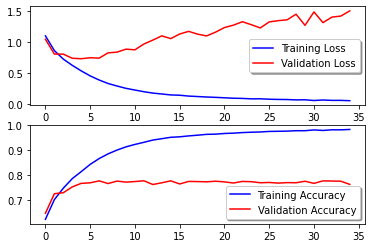

In [13]:
fig, axs = plt.subplots(2,1)
axs[0].plot(history3.history['loss'], color = 'b', label = "Training Loss")
axs[0].plot(history3.history['val_loss'], color = 'r', label = "Validation Loss", axes = axs[0])
legend = axs[0].legend(loc='best', shadow = True)

axs[1].plot(history3.history['accuracy'], color = 'b', label = "Training Accuracy")
axs[1].plot(history3.history['val_accuracy'], color = 'r', label = "Validation Accuracy")
legend = axs[1].legend(loc='best', shadow = True)

In [6]:
from keras.layers import ReLU
from keras.layers import Add

def relu_bn(inputs):
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x, downsample, filters, kernel_size: int = 3):
    y = Conv2D(kernel_size=kernel_size, strides= (1 if not downsample else 2), filters=filters,padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size, strides=1, filters=filters, padding="same")(y)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size, strides=1, filters=filters, padding="same")(y)
    y = relu_bn(y)

    if downsample:
        x = Conv2D(kernel_size=1, strides=2, filters=filters, padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def resnet_architecture():
    
    input_layer = Input(shape=(32, 32, 3))
    
    #model1: block2
    block1_Conv1 =  layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(input_layer)
    block1_MPool1 = layers.MaxPooling2D(2)(block1_Conv1)
    block1_Bn1 =    BatchNormalization()(block1_MPool1)

    block1_Conv2 =  layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(block1_Bn1)
    block1_MPool2 = layers.MaxPooling2D(2)(block1_Conv2)
    block1_Bn2 =    BatchNormalization()(block1_MPool2)
    
    #residual block
    output_residual = residual_block(block1_Bn2, downsample=(True), filters=128)
    
    #dense block
    dense1_dp1 =    Dropout(0.50)(output_residual)
    dense1_flt =    layers.Flatten()(dense1_dp1)

    dense1_dense1 = layers.Dense(512, activation = 'relu')(dense1_flt)
    dense1_Bn1 =    BatchNormalization()(dense1_dense1)
    dense1_dp2 =    Dropout(0.50)(dense1_Bn1)

    output_layer = layers.Dense(10,activation = 'softmax')(dense1_dp2)

    model = Model(inputs = input_layer, outputs = output_layer)
    
    return model

model_res_net = resnet_architecture() # or create_plain_net()'
model_res_net.compile(loss='categorical_crossentropy',
               optimizer= RMSprop(),
               metrics=['accuracy'])
history_res_net = model_res_net.fit(x_train, y_train,
           epochs=6,
           batch_size = 100,
           validation_data = (x_validate, y_validate),
           verbose = 1)     
 

Train on 40000 samples, validate on 10000 samples
Epoch 1/6
40000/40000 [==============================] - 15s 376us/step - loss: 1.6934 - accuracy: 0.4554 - val_loss: 1.2484 - val_accuracy: 0.5598
Epoch 2/6
40000/40000 [==============================] - 8s 191us/step - loss: 1.1009 - accuracy: 0.6166 - val_loss: 1.0332 - val_accuracy: 0.6423
Epoch 3/6
40000/40000 [==============================] - 8s 190us/step - loss: 0.8711 - accuracy: 0.6936 - val_loss: 0.8173 - val_accuracy: 0.7229
Epoch 4/6
40000/40000 [==============================] - 8s 190us/step - loss: 0.7341 - accuracy: 0.7438 - val_loss: 0.7682 - val_accuracy: 0.7457
Epoch 5/6
40000/40000 [==============================] - 8s 188us/step - loss: 0.6233 - accuracy: 0.7781 - val_loss: 0.7105 - val_accuracy: 0.7619
Epoch 6/6
40000/40000 [==============================] - 8s 188us/step - loss: 0.5385 - accuracy: 0.8123 - val_loss: 0.8000 - val_accuracy: 0.7531


In [7]:
loss,accuracy  = model_res_net.evaluate(x_test,y_test)

10000/10000 [==============================] - 2s 159us/step


In [8]:
accuracy,loss

(0.7498000264167786, 0.7932173824071884)

In [0]:
model_res_net.save('cifar-resnet.h5')